In [1]:
import os
import sys
sys.path.insert(0, "..")
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import *
from my_datasets import *
from experiments import *
from experiments.utils.model_loader_utils import *

torch.set_printoptions(sci_mode=False, precision=2, linewidth=120)

In [27]:
n, d, k = 48, 96, 3
path = f"/home/antonxue/foo/tf_logic/_dump/learned_attacks/coerce_state_learned_n{n}_d{d}_k{k}_best.pt"
state_dict = torch.load(path)["model_state_dict"]

In [28]:
res_model, res_dataset = load_model_and_dataset_from_big_grid(embed_dim=d, num_vars=n, seed=601)
atk_model = AttackWrapperModel(res_model, "coerce_state", num_attack_tokens=k)
atk_model.load_state_dict(state_dict)
atk_model.eval()

Querying id: model-SynSAR_gpt2_d96_L1_H1__DMY_nv48_nr32_exph3.000__ntr262144_ntt65536_bsz512_steps8192_lr0.00050_seed601:v0
Downloading: <Artifact QXJ0aWZhY3Q6ODI4ODExOTMz>


wandb:   2 of 2 files downloaded.  


In [29]:
atk_dataset = CoerceStateDataset(res_dataset, k, 1024)
dataloader = DataLoader(atk_dataset, batch_size=1)
for batch in dataloader:
    tokens = batch["tokens"]
    labels = batch["labels"]
    infos = batch["infos"]
    break

with torch.no_grad():
    atk_out = atk_model(tokens=tokens, target=labels[:,0:1], labels=labels)
    atk_rules = atk_out.logits
    atk_ante, atk_conseq = atk_rules.chunk(2, dim=-1)
    adv_tokens = torch.cat([atk_rules, tokens], dim=1)
    adv_out = atk_model.reasoner_model(tokens=adv_tokens, output_attentions=True)
    adv_pred = (adv_out.logits > 0).long()

In [30]:
adv_pred.sum()

tensor(12)

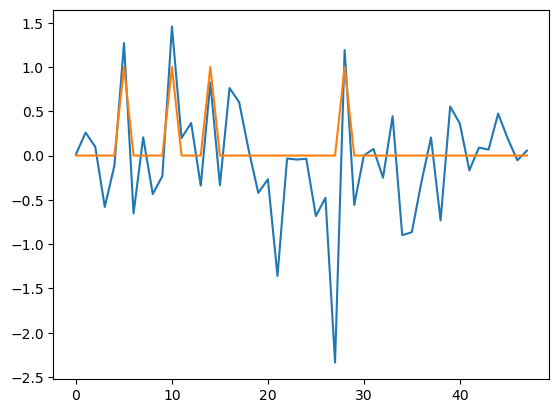

In [31]:
plt.clf()
plt.plot(atk_conseq[0,0].numpy())
plt.plot(labels[0,0].numpy())

In [32]:
labels[:,0].shape

torch.Size([1, 48])

In [8]:
supp_dataset = SuppressRuleDataset(res_dataset, 1024)
dataloader = DataLoader(supp_dataset, batch_size=3)
for batch in dataloader:
    tokens = batch["tokens"]
    labels = batch["labels"]
    infos = batch["infos"]
    supp_idx = batch["supp_idx"]
    a, b = infos[:,0], infos[:,1]

    to_supp_rule = torch.cat([F.one_hot(a,n), F.one_hot(b,n)], dim=-1)    
    to_supp_ind = (tokens == to_supp_rule.view(-1,1,2*n)).all(dim=-1)
    break

with torch.no_grad():
    atk_out = atk_model(tokens=tokens, infos=infos, labels=labels)
    atk_rules = atk_out.logits
    adv_tokens = torch.cat([atk_rules, tokens], dim=1)
    adv_out = atk_model.reasoner_model(tokens=adv_tokens, output_attentions=True)
    adv_pred = adv_out.logits > 0

TypeError: SuppressRuleDataset.__init__() missing 1 required positional argument: 'dataset_len'

In [ ]:
supp_idx

In [ ]:
adv_out.logits.shape

In [ ]:
out1, out2, out3 = adv_out.all_seqcls_outputs

In [ ]:
attn1 = out1.attentions[0][:,0]
attn2 = out2.attentions[0][:,0]
attn3 = out3.attentions[0][:,0]

In [ ]:
attn1.shape

In [ ]:
plt.clf()
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(attn1[0].numpy())
ax[1].imshow(attn2[0].numpy())
ax[2].imshow(attn3[0].numpy())

In [ ]:
attn1.shape, attn1[:,-1]

In [ ]:
atk_wts = attn1[:,-1,:k].sum(dim=-1)
atk_wts

In [ ]:
suppd_wts = attn1[:,-1].gather(1, k+supp_idx.view(-1,1)).view(-1)
suppd_wts

In [ ]:
atk_wts / suppd_wts

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].plot(attn1[0,-1].numpy())
ax[1].plot(attn2[0,-1].numpy())
ax[2].plot(attn3[0,-1].numpy())

In [ ]:
y = torch.randn(2,3,4)
y

In [ ]:
to_supp_ind = (tokens == to_supp_rule).all(dim=-1)
to_supp_ind.shape, to_supp_ind

In [ ]:
x = [torch.rand(()).item() for _ in range(10)]
x

In [ ]:
torch.tensor(x).mean()

In [ ]:
x[-12:]